In [0]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torchvision
import time
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [0]:
# Batch size during training
batch_size = 32

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 101

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

In [0]:
transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
dataset = torchvision.datasets.CIFAR10('./data/', download=True, transform=transform, train=True)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

Files already downloaded and verified


In [0]:
#for i in range(len(dataset)): # or i, image in enumerate(dataset)
#    images, labels = dataset[i] # or whatever your dataset returns

In [0]:
for images, labels in data_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([64, 3, 32, 32])
Image label dimensions: torch.Size([64])


In [0]:
#img, lb = [[imgs, labl] for imgs, labl in dataset]

In [0]:
inputs, classes = next(iter(data_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

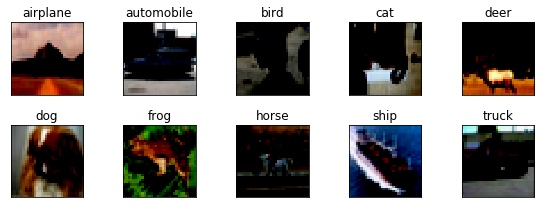

In [0]:
num_classes = len(np.unique(classes))
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    #print(i)
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(classes[:]==i)[0]
    features_idx = inputs[idx,::]
    #print(features_idx.shape[0])
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(np.transpose(img, (1,2,0)))
    
plt.tight_layout()

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        #self.label_embeddings = nn.Embedding(10, 10)

        self.fc = nn.Sequential(
            # FC layer: 2 x 2 x 512
            nn.Linear(nz, 2*2*512),
            nn.BatchNorm1d(2*2*512),
            nn.LeakyReLU(True)
        )
        
        self.model = nn.Sequential(
            # state size. (ngf*8) x 2 x 2
            # to use only ReLU for Generator model
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )

        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0.0, 0.02)
                if m.bias is not None:
                   m.bias.data.zero_()
    
    def forward(self, z, b_size):
        z = z.view(z.size(0), 100)
        #c = self.label_embeddings(labels)
        #print(c)
        #x = torch.cat((c.float(), z.float()), -1)
        x = self.fc(z)
        x = x.view(b_size, 512, 2, 2)
        out = self.model(x)
        #img = img.view(img.size(0), *img_shape)  
        return out #.view(b_size, 3, 32, 32)

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        #self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(  
            # state size. (nc) x 32 x 32

            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False), #64 x 16 x 16
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 2 x 2

            nn.Flatten(),
            # state size. 2*2*512

            nn.Linear(2*2*512, 1),
            nn.Sigmoid()
            # state size. 1
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, 0.02)
                if m.bias is not None:
                    m.bias.data.zero_()
    
    def forward(self, x, labels=None):
        #x = x.view(x.size(0), 3072)
        #c = self.label_emb(labels)
        #print(c)
        #x = torch.cat((c, x), -1)
        out = self.model(x)
        return out.squeeze()

In [0]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

In [0]:
criterion = nn.BCELoss().cuda()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [0]:
# Print model's state_dict
print("Generator's state_dict:")
for param_tensor in generator.state_dict():
    print(param_tensor, "\t", generator.state_dict()[param_tensor].size())
print("--------------------------------------------------------------------------------------")
print("Discriminator's state_dict:")
for param_tensor in discriminator.state_dict():
    print(param_tensor, "\t", discriminator.state_dict()[param_tensor].size())
print("--------------------------------------------------------------------------------------")
# Print optimizer's state_dict
print("Generator Optimizer's state_dict:")
for var_name in g_optimizer.state_dict():
    print(var_name, "\t", g_optimizer.state_dict()[var_name])
print("--------------------------------------------------------------------------------------")
print("Discriminator Optimizer's state_dict:")
for var_name in d_optimizer.state_dict():
    print(var_name, "\t", d_optimizer.state_dict()[var_name])

Generator's state_dict:
fc.0.weight 	 torch.Size([2048, 100])
fc.0.bias 	 torch.Size([2048])
fc.1.weight 	 torch.Size([2048])
fc.1.bias 	 torch.Size([2048])
fc.1.running_mean 	 torch.Size([2048])
fc.1.running_var 	 torch.Size([2048])
fc.1.num_batches_tracked 	 torch.Size([])
model.0.weight 	 torch.Size([512, 256, 4, 4])
model.1.weight 	 torch.Size([256])
model.1.bias 	 torch.Size([256])
model.1.running_mean 	 torch.Size([256])
model.1.running_var 	 torch.Size([256])
model.1.num_batches_tracked 	 torch.Size([])
model.3.weight 	 torch.Size([256, 128, 4, 4])
model.4.weight 	 torch.Size([128])
model.4.bias 	 torch.Size([128])
model.4.running_mean 	 torch.Size([128])
model.4.running_var 	 torch.Size([128])
model.4.num_batches_tracked 	 torch.Size([])
model.6.weight 	 torch.Size([128, 64, 4, 4])
model.7.weight 	 torch.Size([64])
model.7.bias 	 torch.Size([64])
model.7.running_mean 	 torch.Size([64])
model.7.running_var 	 torch.Size([64])
model.7.num_batches_tracked 	 torch.Size([])
model.9.w

In [0]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.FloatTensor(torch.randn(batch_size, nz, 1, 1))).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, batch_size)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    #Use for loop to replace step()
    #Or come up with a function to avoid discriminator being trained as well
    g_optimizer.step()
    return g_loss.item()

In [0]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
    # train with fake images
    z = Variable(torch.FloatTensor(torch.randn(batch_size, nz, 1, 1))).cuda() # can change randn(64, 100, 1, 1) to have randn(64, 100)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, batch_size)
    fake_validity = discriminator(fake_images.detach(), fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    
    d_loss = (real_loss + fake_loss) * 0.5
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

epoch = 1/101, d_loss=0.041, g_loss=6.701                                                                                                     


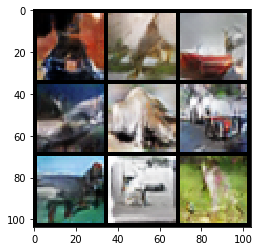

epoch = 2/101, d_loss=0.002, g_loss=5.036                                                                                                     
epoch = 3/101, d_loss=0.000, g_loss=11.390                                                                                                     
epoch = 4/101, d_loss=0.040, g_loss=3.634                                                                                                     
epoch = 5/101, d_loss=0.249, g_loss=1.261                                                                                                     
epoch = 6/101, d_loss=0.002, g_loss=9.628                                                                                                     
epoch = 7/101, d_loss=0.157, g_loss=2.730                                                                                                     
epoch = 8/101, d_loss=0.005, g_loss=8.504                                                                                                    

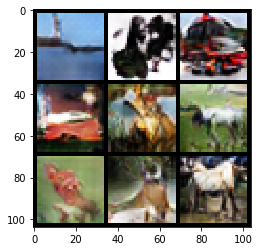

epoch = 12/101, d_loss=0.003, g_loss=4.651                                                                                                     
epoch = 13/101, d_loss=0.016, g_loss=8.138                                                                                                     
epoch = 14/101, d_loss=0.014, g_loss=5.385                                                                                                     
epoch = 15/101, d_loss=0.072, g_loss=4.581                                                                                                     
epoch = 16/101, d_loss=0.126, g_loss=15.208                                                                                                     
epoch = 17/101, d_loss=0.058, g_loss=4.427                                                                                                     
epoch = 18/101, d_loss=0.003, g_loss=7.848                                                                                             

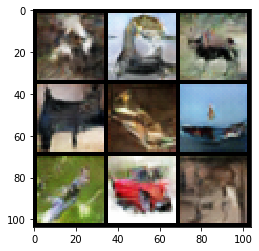

epoch = 22/101, d_loss=0.015, g_loss=11.772                                                                                                     
epoch = 23/101, d_loss=0.249, g_loss=5.857                                                                                                     
epoch = 24/101, d_loss=0.024, g_loss=7.919                                                                                                     
epoch = 25/101, d_loss=0.010, g_loss=9.994                                                                                                     
epoch = 26/101, d_loss=0.001, g_loss=7.878                                                                                                     
epoch = 27/101, d_loss=0.000, g_loss=9.559                                                                                                     
epoch = 28/101, d_loss=0.039, g_loss=4.027                                                                                             

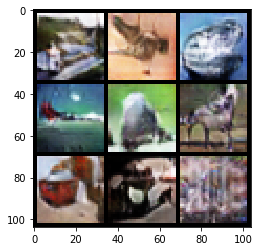

epoch = 32/101, d_loss=0.001, g_loss=7.819                                                                                                     
epoch = 33/101, d_loss=0.000, g_loss=8.662                                                                                                     
epoch = 34/101, d_loss=0.080, g_loss=11.197                                                                                                     
epoch = 35/101, d_loss=0.262, g_loss=15.017                                                                                                     
epoch = 36/101, d_loss=0.082, g_loss=2.719                                                                                                     
epoch = 37/101, d_loss=0.072, g_loss=4.166                                                                                                     
epoch = 38/101, d_loss=1.039, g_loss=0.001                                                                                            

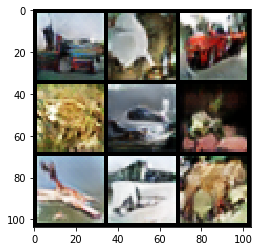

epoch = 42/101, d_loss=0.127, g_loss=6.721                                                                                                     
epoch = 43/101, d_loss=0.001, g_loss=9.562                                                                                                     
epoch = 44/101, d_loss=0.120, g_loss=5.815                                                                                                     
epoch = 45/101, d_loss=0.002, g_loss=1.151                                                                                                     
epoch = 46/101, d_loss=0.002, g_loss=9.462                                                                                                     
epoch = 47/101, d_loss=0.067, g_loss=2.398                                                                                                     
epoch = 48/101, d_loss=0.153, g_loss=1.851                                                                                              

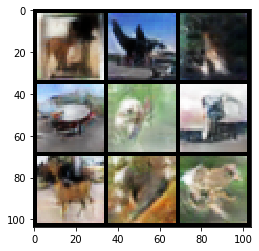

epoch = 52/101, d_loss=0.016, g_loss=8.446                                                                                                     
epoch = 53/101, d_loss=0.108, g_loss=2.136                                                                                                     
epoch = 54/101, d_loss=0.119, g_loss=1.124                                                                                                     
epoch = 55/101, d_loss=0.022, g_loss=9.840                                                                                                     
epoch = 56/101, d_loss=0.108, g_loss=4.347                                                                                                     
epoch = 57/101, d_loss=0.560, g_loss=0.279                                                                                                     
epoch = 58/101, d_loss=0.142, g_loss=6.041                                                                                              

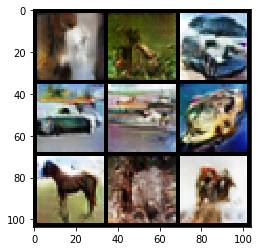

epoch = 62/101, d_loss=0.021, g_loss=7.573                                                                                                     
epoch = 63/101, d_loss=0.000, g_loss=11.690                                                                                                     
epoch = 64/101, d_loss=0.016, g_loss=1.144                                                                                                     
epoch = 65/101, d_loss=0.505, g_loss=1.080                                                                                                     
epoch = 66/101, d_loss=0.481, g_loss=1.994                                                                                                     
epoch = 67/101, d_loss=0.035, g_loss=7.575                                                                                                     
epoch = 68/101, d_loss=0.000, g_loss=5.155                                                                                             

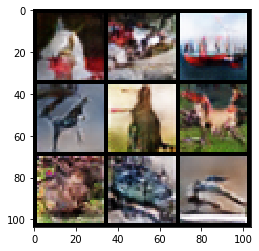

epoch = 72/101, d_loss=0.071, g_loss=6.646                                                                                                     
epoch = 73/101, d_loss=0.015, g_loss=1.260                                                                                                     
epoch = 74/101, d_loss=0.019, g_loss=12.301                                                                                                     
epoch = 75/101, d_loss=0.000, g_loss=14.911                                                                                                     
epoch = 76/101, d_loss=0.002, g_loss=2.195                                                                                                     
epoch = 77/101, d_loss=0.017, g_loss=7.236                                                                                                     
epoch = 78/101, d_loss=0.018, g_loss=12.227                                                                                           

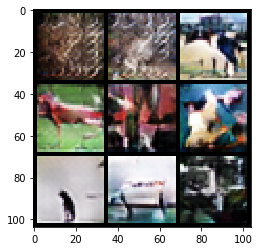

epoch = 82/101, d_loss=0.000, g_loss=9.237                                                                                                     
epoch = 83/101, d_loss=0.194, g_loss=2.070                                                                                                     
epoch = 84/101, d_loss=0.004, g_loss=3.382                                                                                                     
epoch = 85/101, d_loss=0.001, g_loss=9.858                                                                                                     
epoch = 86/101, d_loss=0.004, g_loss=5.379                                                                                                     
epoch = 87/101, d_loss=0.383, g_loss=0.107                                                                                                     
epoch = 88/101, d_loss=0.000, g_loss=7.166                                                                                              

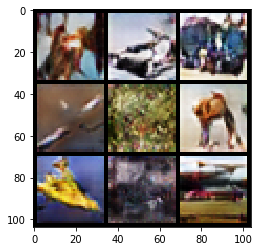

epoch = 92/101, d_loss=0.012, g_loss=2.503                                                                                                     
epoch = 93/101, d_loss=0.001, g_loss=5.877                                                                                                     
epoch = 94/101, d_loss=0.002, g_loss=11.046                                                                                                     
epoch = 95/101, d_loss=0.041, g_loss=10.287                                                                                                     
epoch = 96/101, d_loss=0.000, g_loss=7.943                                                                                                     
epoch = 97/101, d_loss=0.011, g_loss=9.465                                                                                                     
epoch = 98/101, d_loss=0.277, g_loss=3.359                                                                                            

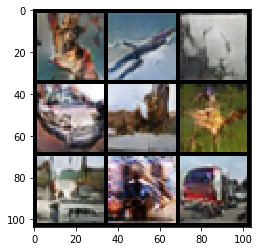

epoch = 102/101, d_loss=0.004, g_loss=0.172                                                                                                     
epoch = 103/101, d_loss=0.000, g_loss=6.619                                                                                                     
epoch = 104/101, d_loss=0.007, g_loss=6.517                                                                                                     
epoch = 105/101, d_loss=0.040, g_loss=10.206                                                                                                     
epoch = 106/101, d_loss=0.017, g_loss=8.121                                                                                                     
epoch = 107/101, d_loss=0.039, g_loss=20.628                                                                                                     
epoch = 108/101, d_loss=0.002, g_loss=9.338                                                                                     

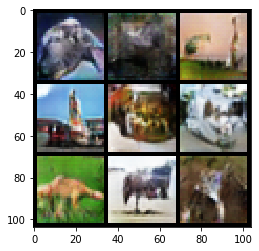

epoch = 112/101, d_loss=0.033, g_loss=5.935                                                                                                     
epoch = 113/101, d_loss=0.022, g_loss=5.080                                                                                                     
epoch = 114/101, d_loss=0.021, g_loss=9.500                                                                                                     
epoch = 115/101, d_loss=0.074, g_loss=8.642                                                                                                     
epoch = 116/101, d_loss=0.599, g_loss=15.644                                                                                                     
epoch = 117/101, d_loss=0.147, g_loss=10.401                                                                                                     
epoch = 118/101, d_loss=0.000, g_loss=8.104                                                                                     

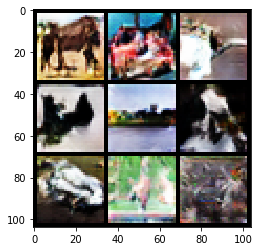

epoch = 122/101, d_loss=0.286, g_loss=11.865                                                                                                     
epoch = 123/101, d_loss=0.148, g_loss=8.689                                                                                                     
epoch = 124/101, d_loss=0.014, g_loss=9.444                                                                                                     
epoch = 125/101, d_loss=0.409, g_loss=0.063                                                                                                     
epoch = 126/101, d_loss=0.000, g_loss=9.989                                                                                                     
epoch = 127/101, d_loss=0.002, g_loss=5.921                                                                                                     
epoch = 128/101, d_loss=0.001, g_loss=11.807                                                                                     

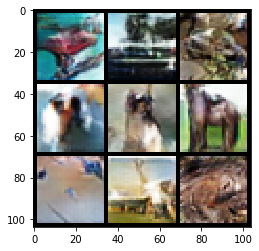

epoch = 132/101, d_loss=0.146, g_loss=9.869                                                                                                     
epoch = 133/101, d_loss=0.027, g_loss=5.061                                                                                                     
epoch = 134/101, d_loss=0.001, g_loss=7.562                                                                                                     
epoch = 135/101, d_loss=0.000, g_loss=10.039                                                                                                     
epoch = 136/101, d_loss=0.039, g_loss=2.326                                                                                                     
epoch = 137/101, d_loss=0.004, g_loss=6.517                                                                                                     
epoch = 138/101, d_loss=0.150, g_loss=8.441                                                                                      

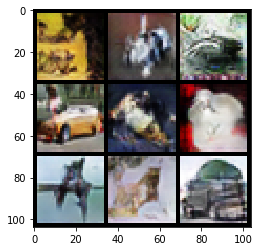

epoch = 142/101, d_loss=0.058, g_loss=10.476                                                                                                     
epoch = 143/101, d_loss=0.003, g_loss=12.114                                                                                                     
epoch = 144/101, d_loss=0.105, g_loss=8.479                                                                                                     
epoch = 145/101, d_loss=0.632, g_loss=0.024                                                                                                     
epoch = 146/101, d_loss=0.000, g_loss=7.051                                                                                                     
epoch = 147/101, d_loss=0.058, g_loss=10.785                                                                                                     
epoch = 148/101, d_loss=0.027, g_loss=10.786                                                                                   

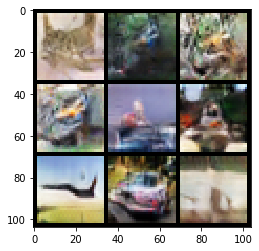

epoch = 152/101, d_loss=0.052, g_loss=8.008                                                                                                     
epoch = 153/101, d_loss=0.332, g_loss=4.195                                                                                                     
epoch = 154/101, d_loss=0.175, g_loss=3.720                                                                                                     
epoch = 155/101, d_loss=0.048, g_loss=12.933                                                                                                     
epoch = 156/101, d_loss=0.000, g_loss=13.556                                                                                                     
epoch = 157/101, d_loss=0.021, g_loss=8.046                                                                                                     
epoch = 158/101, d_loss=0.000, g_loss=10.679                                                                                    

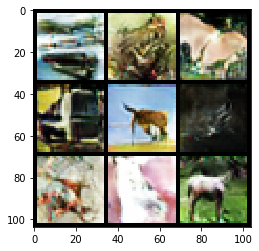

epoch = 162/101, d_loss=0.000, g_loss=9.959                                                                                                     
epoch = 163/101, d_loss=0.050, g_loss=7.555                                                                                                     
epoch = 164/101, d_loss=0.008, g_loss=10.830                                                                                                     
epoch = 165/101, d_loss=0.011, g_loss=10.274                                                                                                     
epoch = 166/101, d_loss=0.160, g_loss=16.993                                                                                                     
epoch = 167/101, d_loss=0.020, g_loss=12.483                                                                                                     
epoch = 168/101, d_loss=0.006, g_loss=4.216                                                                                   

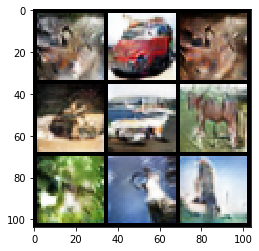

epoch = 172/101, d_loss=0.026, g_loss=9.878                                                                                                     
epoch = 173/101, d_loss=0.013, g_loss=8.497                                                                                                     
epoch = 174/101, d_loss=0.002, g_loss=3.983                                                                                                     
epoch = 175/101, d_loss=0.000, g_loss=14.280                                                                                                     
epoch = 176/101, d_loss=0.751, g_loss=0.461                                                                                                     
epoch = 177/101, d_loss=0.887, g_loss=0.050                                                                                                     
epoch = 178/101, d_loss=0.002, g_loss=2.937                                                                                      

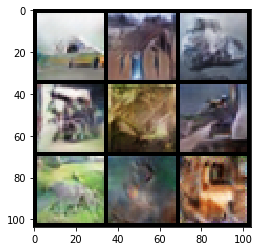

epoch = 182/101, d_loss=0.017, g_loss=3.262                                                                                                     
epoch = 183/101, d_loss=0.741, g_loss=4.445                                                                                                     
epoch = 184/101, d_loss=0.000, g_loss=7.073                                                                                                     
epoch = 185/101, d_loss=0.136, g_loss=12.020                                                                                                     
epoch = 186/101, d_loss=0.005, g_loss=9.118                                                                                                     
epoch = 187/101, d_loss=0.000, g_loss=7.619                                                                                                     
epoch = 188/101, d_loss=0.010, g_loss=10.249                                                                                     

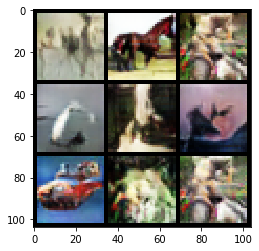

epoch = 192/101, d_loss=0.000, g_loss=8.913                                                                                                     
epoch = 193/101, d_loss=0.118, g_loss=8.209                                                                                                     
epoch = 194/101, d_loss=1.124, g_loss=3.623                                                                                                     
epoch = 195/101, d_loss=0.185, g_loss=12.547                                                                                                     
epoch = 196/101, d_loss=0.000, g_loss=6.294                                                                                                     
epoch = 197/101, d_loss=0.001, g_loss=3.618                                                                                                     
epoch = 198/101, d_loss=0.053, g_loss=10.920                                                                                     

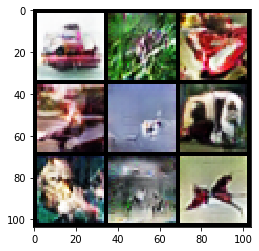

epoch = 202/101, d_loss=0.000, g_loss=13.338                                                                                                     
epoch = 203/101, d_loss=0.000, g_loss=8.112                                                                                                     
epoch = 204/101, d_loss=0.046, g_loss=10.865                                                                                                     
epoch = 205/101, d_loss=0.163, g_loss=16.887                                                                                                     
5843.654928445816


In [0]:
start_time = time.time()
d_loss_tot = []
g_loss_tot = []
for epoch in range(205):
    #print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(data_loader):
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator, generator, d_optimizer, criterion, real_images, labels)    

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    #generator.eval()
    #print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    d_loss_tot.append(d_loss)
    g_loss_tot.append(g_loss)
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (epoch + 1, num_epochs, d_loss, g_loss), 100*' ')
    if epoch % 10 == 0:
      #labels = Variable(torch.LongTensor(np.arange(9))).cuda()
      noise = Variable(torch.FloatTensor(torch.randn(9, nz, 1, 1, requires_grad=False))).cuda()
      sample_images = generator(noise, 9).cpu().data
      sample_images = sample_images.view(sample_images.size(0), 3, 32, 32)
      grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
      plt.imshow(grid)
      plt.show()
elapsed_time = time.time() - start_time
print(elapsed_time)

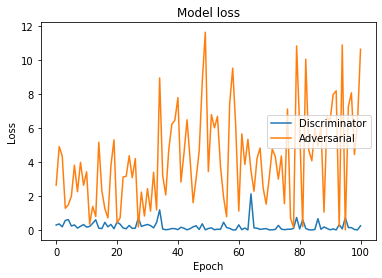

In [0]:
# plotting the metrics
plt.plot(d_loss_tot)
plt.plot(g_loss_tot)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

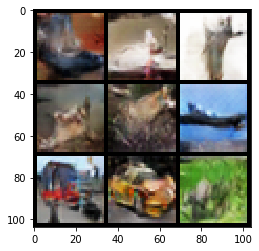

In [0]:
noise = Variable(torch.FloatTensor(torch.randn(9, nz, 1, 1, requires_grad=False))).cuda()
sample_images = generator(noise, 9).cpu().data
sample_images = sample_images.view(sample_images.size(0), 3, 32, 32)
grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
plt.imshow(grid)
plt.show()